### Import useful modules

In [1]:
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import cv2
import pickle
import glob
import time

### Read image files for training and testing

In [2]:
cars = []
notcars = []
for imgfile in glob.glob('vehicles/*/*'):
    img = cv2.imread(imgfile)
    cars.append(img)

for imgfile in glob.glob('non-vehicles/*/*'):
    img = cv2.imread(imgfile)
    notcars.append(img)

for imgfile in glob.glob('negative_mining/*'):
    img = cv2.imread(imgfile)
    notcars.append(img)

pickle.dump(cars, open('cars.p', 'wb'))
pickle.dump(notcars, open('notcars.p', 'wb'))

In [3]:
print("There're {} vehicle images".format(len(cars)))
print("There're {} non-vehicle images".format(len(notcars)))

There're 8792 vehicle images
There're 9011 non-vehicle images


### Functions to extract HOG, spatial binning and color histogram features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# extract bin spatial feature
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# extract color histogram
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='BGR2YCrCb'):
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    raise("Unknown color conversion {}".format(conv))

# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_feature()
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        
        if color_space != 'BGR':
            feature_image = convert_color(image, 'BGR2'+color_space)
        else:
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

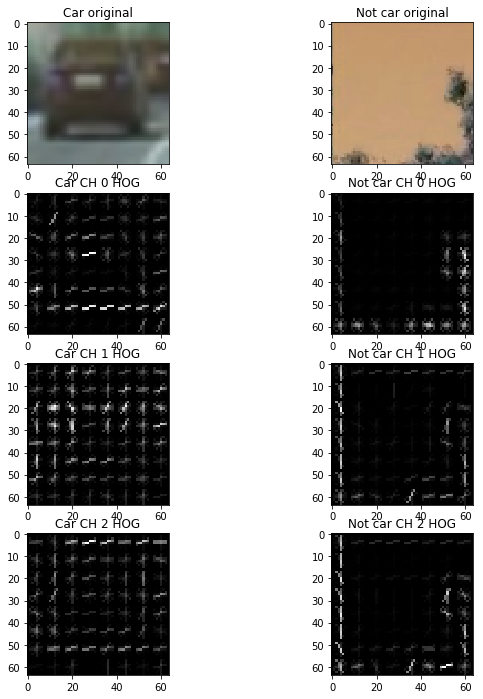

In [5]:
car_img = cv2.cvtColor(cars[0], cv2.COLOR_BGR2YCrCb)
notcar_img = cv2.cvtColor(notcars[0], cv2.COLOR_BGR2YCrCb)
fig = plt.figure(figsize=(10,12))
plt.subplot(4,2,1)
plt.title('Car original')
plt.imshow(cars[0])
plt.subplot(4,2,2)
plt.title('Not car original')
plt.imshow(notcars[0])
i = 0
for ch in range(3):    
    _, hog_img = get_hog_features(car_img[:,:,ch], 9, 8, 8, vis=True, feature_vec=False)
    plt.subplot(4,2,i+3)
    i += 1
    plt.imshow(hog_img, cmap='gray')
    plt.title('Car CH {} HOG'.format(ch))
    _, hog_img = get_hog_features(notcar_img[:,:,ch], 9, 8, 8, vis=True, feature_vec=False)
    plt.subplot(4,2,i+3)
    i += 1
    plt.title('Not car CH {} HOG'.format(ch))
    plt.imshow(hog_img, cmap='gray')
plt.show()

### Prepare dataset
1. Extract features from all images
2. Normalize all features
3. Split dataset into training and testing sets

In [6]:
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


### Train a LinearSVC

In [7]:
# train SVC
svc = svm.LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


In [8]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00383 Seconds to predict 10 labels with SVC


### Define functions used to detect vehicles
It first calculate the HOG feature on the entire image and then slice the feature vector in each sub image in a sliding window algorithm. Also it can optionaly use heat thresholding to weed out false positives and multiple detections. 

In [9]:
# Tracker class to record past frames info
class Tracker():
    def __init__(self):
        self.bboxes_list = []
        self.dump_hard_negative_mining = False
        self.count = 0
        self.dump_heatmap = False

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, tracker, conv,
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    if ystart == None:
        ystart = img.shape[0]//2
    if ystop == None:
        ystop = img.shape[0]
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            hstack_features = np.hstack((spatial_features, hist_features, hog_features))
            hstack_features = hstack_features.reshape(1, -1)
            test_features = X_scaler.transform(hstack_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    if use_heatmap == True:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        tracker.bboxes_list.append(bbox_list)
        
        if use_tracker:
            count = 0
            for bboxes in tracker.bboxes_list[-10:]:
                count += 1 
                heat = add_heat(heat, bboxes)
            if tracker.dump_heatmap:
                cv2.imwrite('heatmap{}.jpg'.format(tracker.count), heat)
                tracker.count += 1
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat, 0.5*count)
        else:
            heat = add_heat(heat, tracker.bboxes_list[-1])
            heat = apply_threshold(heat, 1)

        # Visualize the heatmap when displaying 
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(draw_img, labels)
    else:
        for bbox in bbox_list:
            cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)
    
    if tracker.dump_hard_negative_mining:
        for bbox in bbox_list:
            if bbox[1][0] < img.shape[0]//2 or bbox[1][1] > 3 * img.shape[0]//4:
                debugimg = cv2.resize(img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]], (64,64))
                mpimg.imsave('debug{}.jpg'.format(tracker.count), debugimg)
                tracker.count += 1
    return draw_img

### Test pipeline on individual images

In [10]:
ystart, ystop = None, None # default slide through bottom half
scale = 2
tracker = Tracker()
use_heatmap = True
use_tracker = True
for file in glob.glob('test_images/test?.jpg'):
    img = cv2.imread(file)
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, tracker, 'BGR2YCrCb',
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    outfile = file.split('.')[0] + '_useheatmap.' + file.split('.')[1]
    cv2.imwrite(outfile, out_img)

### Display heatmap 

In [ ]:
fig = plt.figure(figsize=(20,6))
for i,file in enumerate(glob.glob('heatmap*.jpg')):
    img = mpimg.imread(file)
    plt.subplot(2,3,i+1)
    plt.imshow(img, cmap='hot')
fig.tight_layout()
plt.show()

### Display output using heatmap smoothing

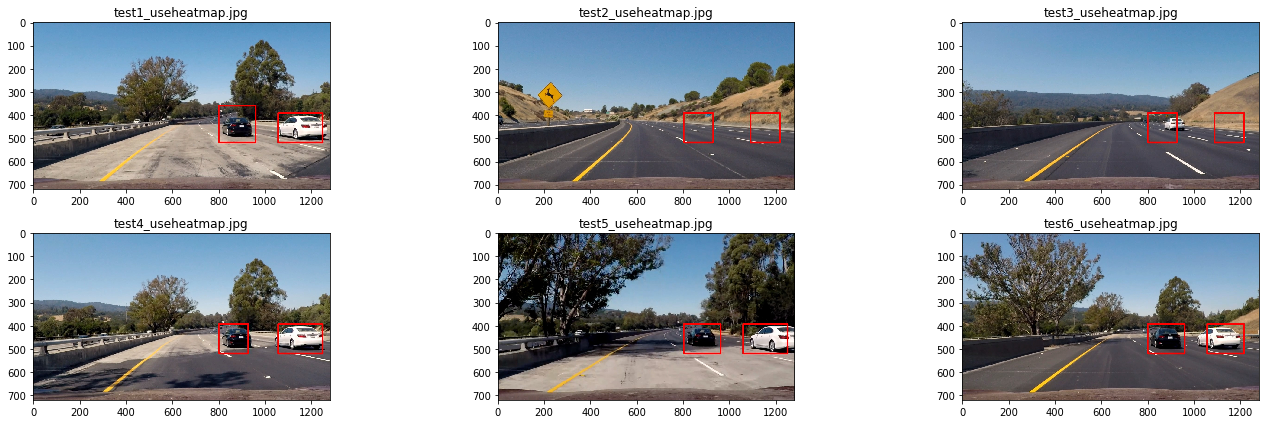

In [12]:
# test model on single image
fig = plt.figure(figsize=(20,6))
for i,file in enumerate(glob.glob('test_images/*_useheatmap.jpg')):
    img = mpimg.imread(file)
    plt.subplot(2,3,i+1)
    plt.title(file.split('/')[1])
    plt.imshow(img)
fig.tight_layout()
plt.show()

### Wrapper function to be used in video detection. Test on a short clip

In [13]:
def process_img(img):
    return find_cars(img, ystart, ystop, scale, svc, X_scaler, tracker, 'RGB2YCrCb',
                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

use_tracker = True
use_heatmap = True
tracker = Tracker()
scale = 1.5
clip = VideoFileClip('test_video.mp4')
clip_processed = clip.fl_image(process_img)
clip_processed.write_videofile('test_video_processed.mp4', audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 97%|█████████▋| 38/39 [00:29<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 



### Run the project video

In [14]:
use_tracker = True
use_heatmap = True
scale = 1.5
tracker = Tracker()
clip = VideoFileClip('project_video.mp4')
clip_processed = clip.fl_image(process_img)
clip_processed.write_videofile('project_video_processed.mp4', audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [16:11<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

